# Plotting

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex
import gizmo_analysis as ga
import sys
sys.path.append('../mock')
import allvariables
import beta

## Access Mock Parameters

Here we are declaring all the `config.yaml` file parameters as local parameters.

In [2]:
# Get the parameters from the config file
params = allvariables.getparamsnotebook()

# Define parameter names
param_names = [
        "snap", "sim", "sim_dir", "sat_id_dir", "rmin", "rmax", "sat_mask", "ananke_name", 
        "photo_sys", "cmd_magnames", "app_mag_lim_lo", "app_mag_lim_hi", 
        "abs_mag_lim_lo", "abs_mag_lim_hi", "ananke_r_max", "fsample"
]

# Initialize parameter dictionary
params_dict = {}

# Assign values to parameters and declare them locally
for param_name, param_value in zip(param_names, params):
    params_dict[param_name] = param_value
    locals()[param_name] = param_value

## Access Ananke Data

Here we are accessing the data with and without the satellite included. Thus, we are working with two different surveys. 

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.anankethon_LSST_outer_m12b.h5")
ananke_sat_file_path = os.path.join(current_dir, "..", "mock", "survey.anankethon_LSST_outer_m12b_sat.h5")
print(f"\nOpening data from: \n{ananke_file_path} \n{ananke_sat_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print(f"{ananke_file_path} file does not exist.")
    
# Check if the file exists
if os.path.exists(ananke_sat_file_path):
    # Proceed with opening the file
    survey_sat = vaex.open(ananke_sat_file_path)
else:
    print(f"{ananke_sat_file_path} file does not exist.")


Opening data from: 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.anankethon_LSST_outer_m12b.h5 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.anankethon_LSST_outer_m12b_sat.h5


In [4]:
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'calcium', 'carbon', 'dec', 'dform', 'dmod', 'feh', 'glat', 'glon', 'grav', 'helium', 'lsst_gmag', 'lsst_gmag_Err', 'lsst_gmag_Intrinsic', 'lsst_gmag_Sig', 'lsst_imag', 'lsst_imag_Err', 'lsst_imag_Intrinsic', 'lsst_imag_Sig', 'lsst_rmag', 'lsst_rmag_Err', 'lsst_rmag_Intrinsic', 'lsst_rmag_Sig', 'lsst_umag', 'lsst_umag_Err', 'lsst_umag_Intrinsic', 'lsst_umag_Sig', 'lsst_ymag', 'lsst_ymag_Err', 'lsst_ymag_Intrinsic', 'lsst_ymag_Sig', 'lsst_zmag', 'lsst_zmag_Err', 'lsst_zmag_Intrinsic', 'lsst_zmag_Sig', 'lum', 'mact', 'magnesium', 'mtip', 'mub', 'mudec', 'mul', 'mura', 'neon', 'nitrogen', 'oxygen', 'parentid', 'partid', 'pi', 'px', 'py', 'pz', 'ra', 'rad', 'silicon', 'smass', 'sulphur', 'teff', 'vr', 'vx', 'vy', 'vz']


## Access FIRE Data

### With Satellite

In [5]:
redshift = 0.
    
part = ga.io.Read.read_snapshots(species='star',
                                 snapshot_value_kind='redshift',
                                 snapshot_values=redshift,
                                 simulation_directory=sim_dir,
                                 elements='all',
                                 assign_hosts=True,
                                 assign_hosts_rotation=True,
                                 assign_orbits=True)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/data/fire2/m12b_res7100/snapshot_times.txt

* input redshift = 0.0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/data/fire2/m12b_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 58588459 particles
    star      (id = 4): 16869462 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5
    snapshot_600.4.hdf5
    snapshot_600.5.hdf5
    snapshot_600.6.hdf5
    snapshot_600.7.hdf5

* reading cosmological parameters from:  home/jovyan/data/fire2/m12b_res7100/initial_condition/ic_agora_m12b.conf

* checking sanity of particle properties
! 

### Without Satellite

In [6]:
# array of positions in principal axes (in kpc)
pos_pa = part['star'].prop('host.distance.principal')

# Blank satellite mask
satellite_mask = np.ones(len(pos_pa), dtype=bool)
    
# Store satellite indices (from Mia)
all_unique_lmc_inds = np.loadtxt(sat_id_dir)
all_inds = part['star'].prop('id')
remaining_indices = np.setdiff1d(all_inds, np.array(all_unique_lmc_inds))
id_indices = np.where(np.isin(all_inds, remaining_indices))[0]
only_lmc_indices = np.where(~np.isin(all_inds, remaining_indices))[0]
    
# Remove satellite
satellite_mask[only_lmc_indices] = False

## Extract Parameters

In [10]:
# Define the bin edges
bins = 200

In [11]:
# Create a binned radius array 
dr = np.linspace(0, rmax, bins)

### 1. Data before ananke (FIRE)

### With Satellite

In [12]:
firePos = part['star'].prop('host.distance') # star position in kpc
fireMass = part['star']['mass']              # star mass in Msun
fireVel = part['star'].prop('host.velocity') # star velocity in km/s

In [13]:
# Compute radial distance
fireRadial = np.sqrt((firePos[:,0])**2 + (firePos[:,1])**2 + (firePos[:,2])**2)

# Compute the FIRE density profile
fireCounts, fireEdges = np.histogram(fireRadial, bins=bins, range=(rmin, rmax))
fireVolume = 4.0/3.0 * np.pi * (np.power(fireEdges[1:], 3) - np.power(fireEdges[:-1], 3))
fireDensity = fireCounts / fireVolume

In [14]:
# Call the velocity dispersion function from beta.py
fire_vr_disp_r, fire_vtheta_disp_r, fire_vphi_disp_r = beta.velocity_dispersions_r(firePos, fireVel, bins, rmax)

# Calculate radial velocity dispersion 
fire_v_disp = (fire_vtheta_disp_r**2 + fire_vphi_disp_r**2)**0.5

### Without Satellite

In [15]:
firePosSat = firePos[satellite_mask]
fireMassSat = fireMass[satellite_mask]
fireVelSat = fireVel[satellite_mask]

In [16]:
# Compute radial distance
fireRadialSat = np.sqrt((firePosSat[:,0])**2 + (firePosSat[:,1])**2 + (firePosSat[:,2])**2)

# Compute the FIRE density profile
fireCountsSat, fireEdgesSat = np.histogram(fireRadialSat, bins=bins, range=(rmin, rmax))
fireVolumeSat = 4.0/3.0 * np.pi * (np.power(fireEdgesSat[1:], 3) - np.power(fireEdgesSat[:-1], 3))
fireDensitySat = fireCountsSat / fireVolumeSat

In [17]:
# Call the velocity dispersion function from beta.py
fire_vr_disp_r_sat, fire_vtheta_disp_r_sat, fire_vphi_disp_r_sat = beta.velocity_dispersions_r(firePosSat, fireVelSat, bins, rmax)

# Calculate radial velocity dispersion 
fire_v_disp_sat = (fire_vtheta_disp_r_sat**2 + fire_vphi_disp_r_sat**2)**0.5

### 2. Data after ananke

### With Satellite

In [20]:
# Extract parameters
anankeRadial = survey.rad.to_numpy()
anankeMass = survey.smass.to_numpy()            

In [21]:
# Compute the ananke density profile
anankeCounts, anankeEdges = np.histogram(anankeRadial, bins=bins, range=(rmin, rmax))
anankeVolume = 4.0/3.0 * np.pi * (np.power(anankeEdges[1:], 3) - np.power(anankeEdges[:-1], 3))
anankeDensity = anankeCounts / anankeVolume

In [22]:
# Extract pos and vel
anankePos = np.stack((survey.px.to_numpy(), survey.py.to_numpy(), survey.pz.to_numpy())).T
anankeVel = np.stack((survey.vx.to_numpy(), survey.vy.to_numpy(), survey.vz.to_numpy())).T

In [23]:
# Call the velocity dispersion function from beta.py
ananke_vr_disp_r, ananke_vtheta_disp_r, ananke_vphi_disp_r = beta.velocity_dispersions_r(anankePos, anankeVel, bins, rmax)

# Calculate radial velocity dispersion 
ananke_v_disp = (ananke_vtheta_disp_r**2 + ananke_vphi_disp_r**2)**0.5

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Without Satellite

In [25]:
# Extract parameters
anankeRadialSat = survey_sat.rad.to_numpy()
anankeMassSat = survey_sat.smass.to_numpy()                   

In [26]:
# Compute the ananke density profile
anankeCountsSat, anankeEdgesSat = np.histogram(anankeRadialSat, bins=bins, range=(rmin, rmax))
anankeVolumeSat = 4.0/3.0 * np.pi * (np.power(anankeEdgesSat[1:], 3) - np.power(anankeEdgesSat[:-1], 3))
anankeDensitySat = anankeCountsSat / anankeVolumeSat

In [27]:
# Extract pos and vel
anankePosSat = np.stack((survey_sat.px.to_numpy(), survey_sat.py.to_numpy(), survey_sat.pz.to_numpy())).T
anankeVelSat = np.stack((survey_sat.vx.to_numpy(), survey_sat.vy.to_numpy(), survey_sat.vz.to_numpy())).T

In [28]:
# Call the velocity dispersion function from beta.py
ananke_vr_disp_r_sat, ananke_vtheta_disp_r_sat, ananke_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat, anankeVelSat, bins, rmax)

# Calculate radial velocity dispersion 
ananke_v_disp_sat = (ananke_vtheta_disp_r_sat**2 + ananke_vphi_disp_r_sat**2)**0.5

### 3. BHB

To select BHB stars  we use $ 0.98 < u − g < 1.28$, $−0.27 < g − r < −0.06$ and excluding the region $([u−g −0.98]/0.215)2 + ([g −r+ 0.06]/0.17)2 < 1$.

### With Satellite

In [29]:
# Extract apparent magnitudes
app_g_mag = survey.lsst_gmag.to_numpy()
app_r_mag = survey.lsst_rmag.to_numpy()
app_i_mag = survey.lsst_imag.to_numpy()
app_u_mag = survey.lsst_umag.to_numpy()
app_y_mag = survey.lsst_ymag.to_numpy()
app_z_mag = survey.lsst_zmag.to_numpy()

In [30]:
# Calculate u - g
u_minus_g = app_u_mag - app_g_mag

In [31]:
# Calculate g - r
g_minus_r = app_g_mag - app_r_mag

In [32]:
# Create BHB mask
bhb_mask = ((u_minus_g > 0.98) & (u_minus_g < 1.28) &
            (g_minus_r > -0.27) & (g_minus_r < -0.06) &
            ((((u_minus_g - 0.215) / 0.215) * 2 + ((g_minus_r + 0.06) / 0.17) * 2) >= 1))

In [33]:
# Compute the BHB density profile
bhbCounts, bhbEdges = np.histogram(anankeRadial[bhb_mask], bins=bins, range=(rmin, rmax))
bhbVolume = 4.0/3.0 * np.pi * (np.power(bhbEdges[1:], 3) - np.power(bhbEdges[:-1], 3))
bhbDensity = bhbCounts / bhbVolume

In [34]:
# Call the velocity dispersion function from beta.py
bhb_vr_disp_r, bhb_vtheta_disp_r, bhb_vphi_disp_r = beta.velocity_dispersions_r(anankePos[bhb_mask], anankeVel[bhb_mask], bins, rmax)

# Calculate radial velocity dispersion 
bhb_v_disp = (bhb_vtheta_disp_r**2 + bhb_vphi_disp_r**2)**0.5

### Without Satellite

In [35]:
# Extract apparent magnitudes
app_g_mag_sat = survey_sat.lsst_gmag.to_numpy()
app_r_mag_sat = survey_sat.lsst_rmag.to_numpy()
app_i_mag_sat = survey_sat.lsst_imag.to_numpy()
app_u_mag_sat = survey_sat.lsst_umag.to_numpy()
app_y_mag_sat = survey_sat.lsst_ymag.to_numpy()
app_z_mag_sat = survey_sat.lsst_zmag.to_numpy()

In [36]:
# Calculate u - g
u_minus_g_sat = app_u_mag_sat - app_g_mag_sat

In [37]:
# Calculate g - r
g_minus_r_sat = app_g_mag_sat - app_r_mag_sat

In [38]:
# Create BHB mask
bhb_mask_sat = ((u_minus_g_sat > 0.98) & (u_minus_g_sat < 1.28) &
            (g_minus_r_sat > -0.27) & (g_minus_r_sat < -0.06) &
            ((((u_minus_g_sat - 0.215) / 0.215) * 2 + ((g_minus_r_sat + 0.06) / 0.17) * 2) >= 1))

In [39]:
# Compute the BHB density profile
bhbCountsSat, bhbEdgesSat = np.histogram(anankeRadialSat[bhb_mask_sat], bins=bins, range=(rmin, rmax))
bhbVolumeSat = 4.0/3.0 * np.pi * (np.power(bhbEdgesSat[1:], 3) - np.power(bhbEdgesSat[:-1], 3))
bhbDensitySat = bhbCountsSat / bhbVolumeSat

In [40]:
# Call the velocity dispersion function from beta.py
bhb_vr_disp_r_sat, bhb_vtheta_disp_r_sat, bhb_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[bhb_mask_sat], anankeVelSat[bhb_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
bhb_v_disp_sat = (bhb_vtheta_disp_r_sat**2 + bhb_vphi_disp_r_sat**2)**0.5

### 4. K Giant

In order to isolate K giants in our stellar halo models we have used the colour cuts $0.5 < g − r < 1.3$ and $0.5 <
u−g < 3.5$ from Xue et al. (2014), along with their proposed empirical polynomial relation between (g −r) and [Fe/H] to remove red horizontal branch and red-clump (RC) giants. All stars with $(g − r) > 0.087 [Fe/H]2 + 0.39 [Fe/H] + 0.96$ is excluded from the selection. An additional cut of $M_g < 4$ removes faint dwarf stars of the same colours

### With Satellite

In [42]:
# Extract absolute magnitudes
# NOTE: THIS VALUE IS NOT ACTUALLY ABS MAGNITUDE
g_mag = survey.lsst_gmag_Intrinsic.to_numpy()
r_mag = survey.lsst_rmag_Intrinsic.to_numpy()
i_mag = survey.lsst_imag_Intrinsic.to_numpy()
u_mag = survey.lsst_umag_Intrinsic.to_numpy()
y_mag = survey.lsst_ymag_Intrinsic.to_numpy()
z_mag = survey.lsst_zmag_Intrinsic.to_numpy()

In [43]:
# Extract metalicity
feh = survey.feh.to_numpy()

In [44]:
# Create K Giant mask
kgiant_mask = ((g_minus_r > 0.5) & (g_minus_r < 1.3) &
               (u_minus_g > 0.5) & (u_minus_g < 3.5) &
               (g_minus_r <= ((0.087 * feh * 2) + (0.39 * feh) + 0.96)) & 
               (g_mag < 4))

In [45]:
# Compute the K Giant density profile
kgiantCounts, kgiantEdges = np.histogram(anankeRadial[kgiant_mask], bins=bins, range=(rmin, rmax))
kgiantVolume = 4.0/3.0 * np.pi * (np.power(kgiantEdges[1:], 3) - np.power(kgiantEdges[:-1], 3))
kgiantDensity = kgiantCounts / kgiantVolume

In [46]:
# Call the velocity dispersion function from beta.py
kgiant_vr_disp_r, kgiant_vtheta_disp_r, kgiant_vphi_disp_r = beta.velocity_dispersions_r(anankePos[kgiant_mask], anankeVel[kgiant_mask], bins, rmax)

# Calculate radial velocity dispersion 
kgiant_v_disp = (kgiant_vtheta_disp_r**2 + kgiant_vphi_disp_r**2)**0.5

### Without Satellite

In [41]:
# Extract absolute magnitudes
# NOTE: THIS VALUE IS NOT ACTUALLY ABS MAGNITUDE
g_mag_sat = survey_sat.lsst_gmag_Intrinsic.to_numpy()
r_mag_sat = survey_sat.lsst_rmag_Intrinsic.to_numpy()
i_mag_sat = survey_sat.lsst_imag_Intrinsic.to_numpy()
u_mag_sat = survey_sat.lsst_umag_Intrinsic.to_numpy()
y_mag_sat = survey_sat.lsst_ymag_Intrinsic.to_numpy()
z_mag_sat = survey_sat.lsst_zmag_Intrinsic.to_numpy()

In [47]:
# Extract metalicity
feh_sat = survey_sat.feh.to_numpy()

In [48]:
# Create K Giant mask
kgiant_mask_sat = ((g_minus_r_sat > 0.5) & (g_minus_r_sat < 1.3) &
               (u_minus_g_sat > 0.5) & (u_minus_g_sat < 3.5) &
               (g_minus_r_sat <= ((0.087 * feh_sat * 2) + (0.39 * feh_sat) + 0.96)) & 
               (g_mag_sat < 4))

In [49]:
# Compute the K Giant density profile
kgiantCountsSat, kgiantEdgesSat = np.histogram(anankeRadialSat[kgiant_mask_sat], bins=bins, range=(rmin, rmax))
kgiantVolumeSat = 4.0/3.0 * np.pi * (np.power(kgiantEdgesSat[1:], 3) - np.power(kgiantEdgesSat[:-1], 3))
kgiantDensitySat = kgiantCountsSat / kgiantVolumeSat

In [50]:
# Call the velocity dispersion function from beta.py
kgiant_vr_disp_r_sat, kgiant_vtheta_disp_r_sat, kgiant_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[kgiant_mask_sat], anankeVelSat[kgiant_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
kgiant_v_disp_sat = (kgiant_vtheta_disp_r_sat**2 + kgiant_vphi_disp_r_sat**2)**0.5

### 5. MSTO

To select main sequence turn off stars we use $ 0.2 < g−r < 0.4$ and $M_g > 4$.

### With Satellite

In [51]:
# Create MSTO mask
msto_mask = (g_minus_r > 0.2) & (g_minus_r < 0.4) & (g_mag > 4)

In [52]:
# Compute the MSTO density profile
mstoCounts, mstoEdges = np.histogram(anankeRadial[msto_mask], bins=bins, range=(rmin, rmax))
mstoVolume = 4.0/3.0 * np.pi * (np.power(mstoEdges[1:], 3) - np.power(mstoEdges[:-1], 3))
mstoDensity = mstoCounts / mstoVolume

In [53]:
# Call the velocity dispersion function from beta.py
msto_vr_disp_r, msto_vtheta_disp_r, msto_vphi_disp_r = beta.velocity_dispersions_r(anankePos[msto_mask], anankeVel[msto_mask], bins, rmax)

# Calculate radial velocity dispersion 
msto_v_disp = (msto_vtheta_disp_r**2 + msto_vphi_disp_r**2)**0.5

### Without Satellite

In [54]:
# Create MSTO mask
msto_mask_sat = (g_minus_r_sat > 0.2) & (g_minus_r_sat < 0.4) & (g_mag_sat > 4)

In [55]:
# Compute the MSTO density profile
mstoCountsSat, mstoEdgesSat = np.histogram(anankeRadialSat[msto_mask_sat], bins=bins, range=(rmin, rmax))
mstoVolumeSat = 4.0/3.0 * np.pi * (np.power(mstoEdgesSat[1:], 3) - np.power(mstoEdgesSat[:-1], 3))
mstoDensitySat = mstoCountsSat / mstoVolumeSat

In [56]:
# Call the velocity dispersion function from beta.py
msto_vr_disp_r_sat, msto_vtheta_disp_r_sat, msto_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[msto_mask_sat], anankeVelSat[msto_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
msto_v_disp_sat = (msto_vtheta_disp_r_sat**2 + msto_vphi_disp_r_sat**2)**0.5

## Individual Plots

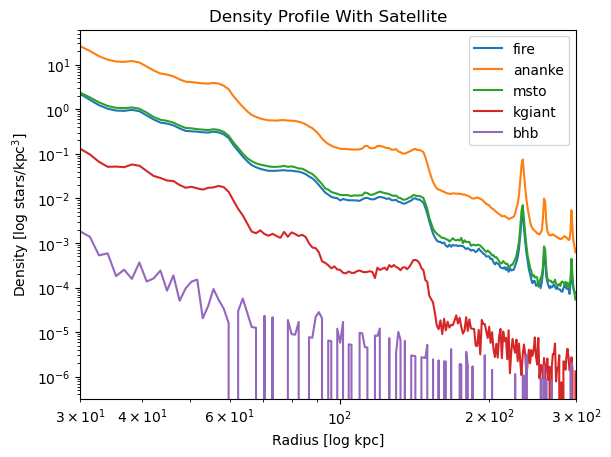

In [62]:
# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(fireEdges[:-1], fireDensity, label='fire')
ax.loglog(anankeEdges[:-1], anankeDensity, label='ananke')
ax.loglog(mstoEdges[:-1], mstoDensity, label='msto')
ax.loglog(kgiantEdges[:-1], kgiantDensity, label='kgiant')
ax.loglog(bhbEdges[:-1], bhbDensity, label='bhb')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.set_ylim()
ax.legend()
plt.title('Density Profile With Satellite')
plt.show()

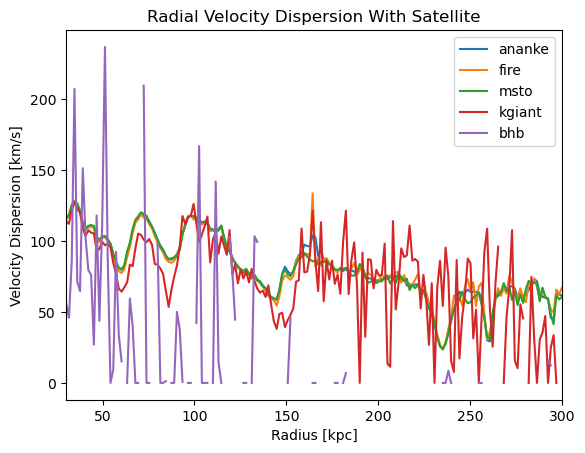

In [63]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_vr_disp_r, label='ananke')
ax.plot(dr[1:], fire_vr_disp_r, label='fire')
ax.plot(dr[1:], msto_vr_disp_r, label='msto')
ax.plot(dr[1:], kgiant_vr_disp_r, label='kgiant')
ax.plot(dr[1:], bhb_vr_disp_r, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Radial Velocity Dispersion With Satellite')
plt.show()

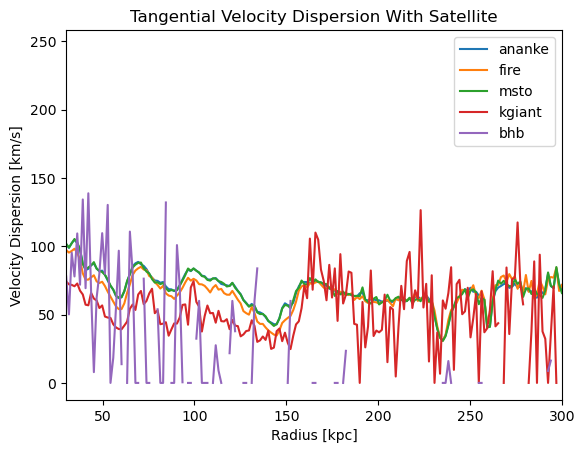

In [64]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_v_disp, label='ananke')
ax.plot(dr[1:], fire_v_disp, label='fire')
ax.plot(dr[1:], msto_v_disp, label='msto')
ax.plot(dr[1:], kgiant_v_disp, label='kgiant')
ax.plot(dr[1:], bhb_v_disp, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Tangential Velocity Dispersion With Satellite')
plt.show()

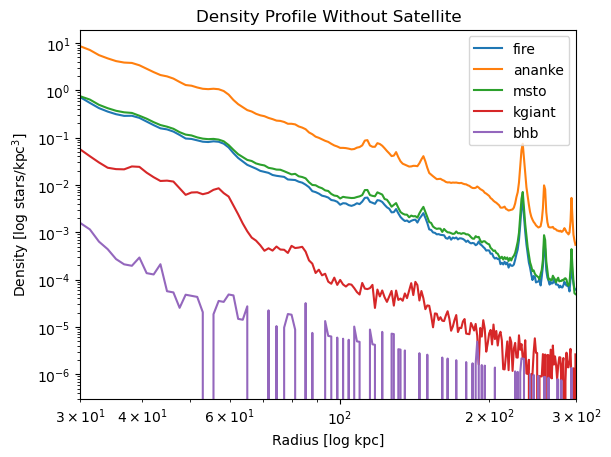

In [65]:
# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(fireEdgesSat[:-1], fireDensitySat, label='fire')
ax.loglog(anankeEdgesSat[:-1], anankeDensitySat, label='ananke')
ax.loglog(mstoEdgesSat[:-1], mstoDensitySat, label='msto')
ax.loglog(kgiantEdgesSat[:-1], kgiantDensitySat, label='kgiant')
ax.loglog(bhbEdgesSat[:-1], bhbDensitySat, label='bhb')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.set_ylim()
ax.legend()
plt.title('Density Profile Without Satellite')
plt.show()

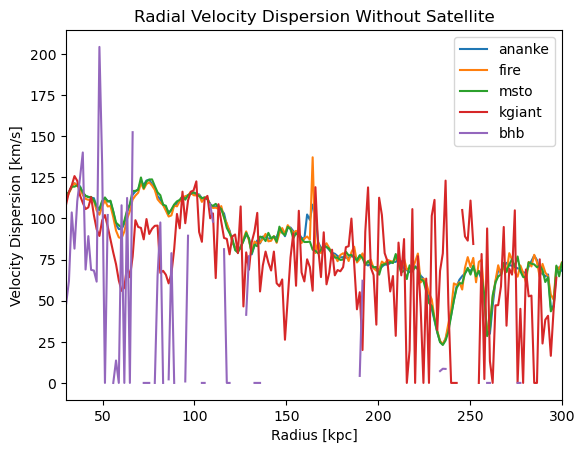

In [66]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_vr_disp_r_sat, label='ananke')
ax.plot(dr[1:], fire_vr_disp_r_sat, label='fire')
ax.plot(dr[1:], msto_vr_disp_r_sat, label='msto')
ax.plot(dr[1:], kgiant_vr_disp_r_sat, label='kgiant')
ax.plot(dr[1:], bhb_vr_disp_r_sat, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Radial Velocity Dispersion Without Satellite')
plt.show()

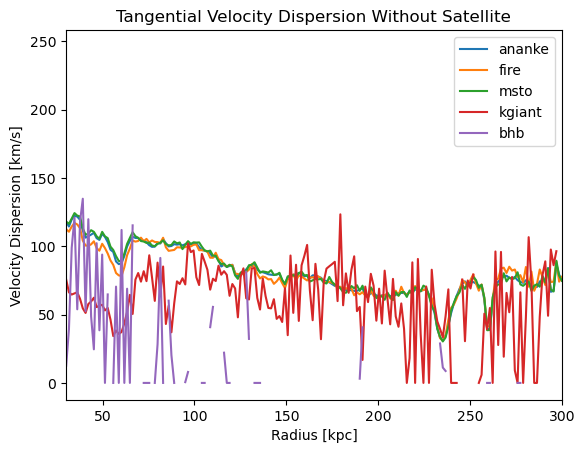

In [67]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_v_disp_sat, label='ananke')
ax.plot(dr[1:], fire_v_disp_sat, label='fire')
ax.plot(dr[1:], msto_v_disp_sat, label='msto')
ax.plot(dr[1:], kgiant_v_disp_sat, label='kgiant')
ax.plot(dr[1:], bhb_v_disp_sat, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Tangential Velocity Dispersion Without Satellite')
plt.show()

## Combined Plot

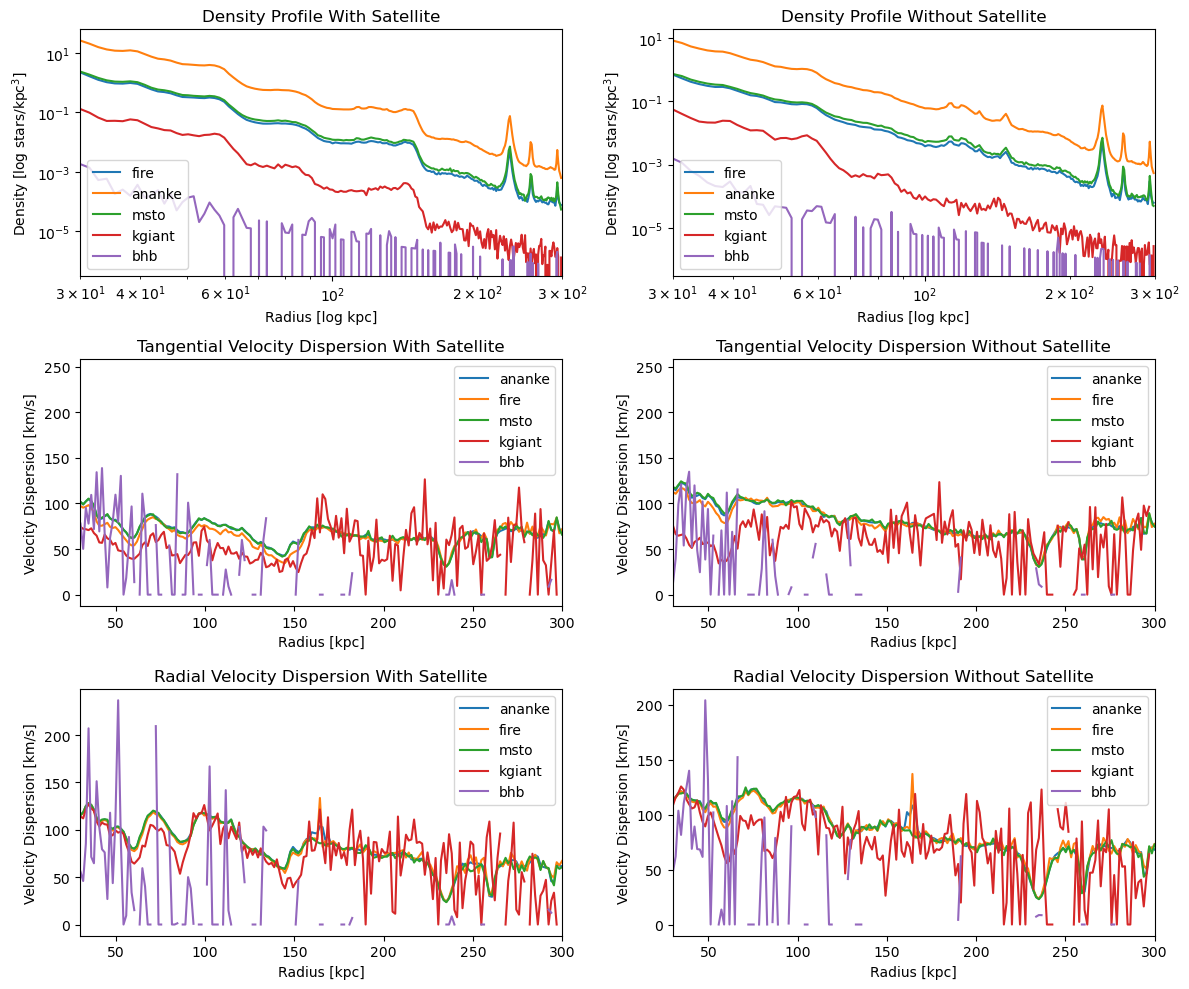

In [69]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # 2 rows, 2 columns

axes[0, 0].loglog(fireEdges[:-1], fireDensity, label='fire')
axes[0, 0].loglog(anankeEdges[:-1], anankeDensity, label='ananke')
axes[0, 0].loglog(mstoEdges[:-1], mstoDensity, label='msto')
axes[0, 0].loglog(kgiantEdges[:-1], kgiantDensity, label='kgiant')
axes[0, 0].loglog(bhbEdges[:-1], bhbDensity, label='bhb')
axes[0, 0].set_xlabel('Radius [log kpc]')
axes[0, 0].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 0].set_xlim(rmin, rmax)
axes[0, 0].set_ylim()
axes[0, 0].legend()
axes[0, 0].set_title('Density Profile With Satellite')

axes[0, 1].loglog(fireEdgesSat[:-1], fireDensitySat, label='fire')
axes[0, 1].loglog(anankeEdgesSat[:-1], anankeDensitySat, label='ananke')
axes[0, 1].loglog(mstoEdgesSat[:-1], mstoDensitySat, label='msto')
axes[0, 1].loglog(kgiantEdgesSat[:-1], kgiantDensitySat, label='kgiant')
axes[0, 1].loglog(bhbEdgesSat[:-1], bhbDensitySat, label='bhb')
axes[0, 1].set_xlabel('Radius [log kpc]')
axes[0, 1].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 1].set_xlim(rmin, rmax)
axes[0, 1].set_ylim()
axes[0, 1].legend()
axes[0, 1].set_title('Density Profile Without Satellite')

axes[1, 0].plot(dr[1:], ananke_v_disp, label='ananke')
axes[1, 0].plot(dr[1:], fire_v_disp, label='fire')
axes[1, 0].plot(dr[1:], msto_v_disp, label='msto')
axes[1, 0].plot(dr[1:], kgiant_v_disp, label='kgiant')
axes[1, 0].plot(dr[1:], bhb_v_disp, label='bhb')
axes[1, 0].set_xlabel('Radius [kpc]')
axes[1, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 0].set_xlim(rmin, rmax)
axes[1, 0].legend()
axes[1, 0].set_title('Tangential Velocity Dispersion With Satellite')

axes[1, 1].plot(dr[1:], ananke_v_disp_sat, label='ananke')
axes[1, 1].plot(dr[1:], fire_v_disp_sat, label='fire')
axes[1, 1].plot(dr[1:], msto_v_disp_sat, label='msto')
axes[1, 1].plot(dr[1:], kgiant_v_disp_sat, label='kgiant')
axes[1, 1].plot(dr[1:], bhb_v_disp_sat, label='bhb')
axes[1, 1].set_xlabel('Radius [kpc]')
axes[1, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 1].set_xlim(rmin, rmax)
axes[1, 1].legend()
axes[1, 1].set_title('Tangential Velocity Dispersion Without Satellite')

axes[2, 0].plot(dr[1:], ananke_vr_disp_r, label='ananke')
axes[2, 0].plot(dr[1:], fire_vr_disp_r, label='fire')
axes[2, 0].plot(dr[1:], msto_vr_disp_r, label='msto')
axes[2, 0].plot(dr[1:], kgiant_vr_disp_r, label='kgiant')
axes[2, 0].plot(dr[1:], bhb_vr_disp_r, label='bhb')
axes[2, 0].set_xlabel('Radius [kpc]')
axes[2, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 0].set_xlim(rmin, rmax)
axes[2, 0].legend()
axes[2, 0].set_title('Radial Velocity Dispersion With Satellite')

axes[2, 1].plot(dr[1:], ananke_vr_disp_r_sat, label='ananke')
axes[2, 1].plot(dr[1:], fire_vr_disp_r_sat, label='fire')
axes[2, 1].plot(dr[1:], msto_vr_disp_r_sat, label='msto')
axes[2, 1].plot(dr[1:], kgiant_vr_disp_r_sat, label='kgiant')
axes[2, 1].plot(dr[1:], bhb_vr_disp_r_sat, label='bhb')
axes[2, 1].set_xlabel('Radius [kpc]')
axes[2, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 1].set_xlim(rmin, rmax)
axes[2, 1].legend()
axes[2, 1].set_title('Radial Velocity Dispersion Without Satellite')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()